# Project 2 Ames Housing



## Data description

The data set consists of housing prices and roughly 80 attributes describing the property and structure for Ames, IA.  Both the training and test sets included data from years 2006 to 2010. A data dictionary can be found at the end of this notebook.

The target variable is the sale price (SalePrice) and the other fields are considered independent variables used to model this value.



## Imports

In [1]:
# Imports:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Set the graph style
sns.set_style('whitegrid')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Read in data

In [2]:
# Set relative data path
data_path = "../datasets"
test_file_name = "test.csv"
train_file_name = "train.csv"

a_tst = pd.read_csv(os.path.join(data_path, test_file_name))
a_trn = pd.read_csv(os.path.join(data_path, train_file_name))


### View dataframes and data

1. Look at all columns for both the train and test data sets
2. Pick a set of features to examine first
3. Explore these features individually


In [3]:
# Look at the train and test data sets
print("Train", a_trn.shape)
print(a_trn.columns)
# print(a_trn.info())

print ("Test", a_tst.shape)
print(a_tst.columns)
# print(a_tst.info())


Train (2051, 81)
Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Y

### Variable notes

* Excluded from analysis
    * Low Qual Fin SF has only 33 values that are not zero
    * 1st Flr SF + 2nd Flr SF = Gr Liv Area except for 33 values used Gr Liv Area
    * Lot Frontage has 330 missing values

    
* Missing values (NaN values)
    * Set Bsmt Full Bath NaN values to 0 (2 values)
    * Set Bsmt Half Bath NaN values to 0 (2 values)
    * Set Total Bsmt SF NaN values to 0 (1 values)
    * Set Bsmt Cond NaN values to NA (55 values in train dataset)
    * Set Garage Type NaN values to NA (113 values in train dataset)
    * Set Pool QC values to NA (2042 values in train dataset)
    * Set Misc Features values to NA (1986 values in train dataset)
        

## Establish Functions

In [4]:
# Function to streamline min, max, type and null
def print_summary(df):
    for column in df.columns:
        try:
            col_type = df[column].dtype
        except:
            col_type = 'XXX'
        print("Column: %15s  min: %10s  max: %10s  type: %10s  null: %10s" % (column, 
                                                              str(df[column].min()), 
                                                              str(df[column].max()),
                                                              str(col_type),
                                                              str(df[column].isnull().sum())))
          

# Function to compare value counts in the first data frame to others
def compare_value_counts(df_list, col):

    # Print headers
    print("Column: %10s " % col)
    for i in range(len(df_list)):
        print("%20s" % ("Dataframe "+str(i)), end=" ")
    print("\n")
    # Print the value counts in each data frame
    for val in df_list[0][col].value_counts().index:
        i = 0
        for df in df_list:
            if i == len(df_list) - 1:
                print("%10s %10s" % (val, df[df[col]==val][col].count()))
            else:
                print("%10s %10s" % (val, df[df[col]==val][col].count()), end =" ")                    
            i += 1
    print("\n")
    
    
# function plot histograms using seaborn distplot
def subplot_histograms(df, list_of_cols, 
                       list_of_titles, 
                       list_of_xlabels,
                       list_of_ylabels, 
                       figsize):
    
    # Makes sure you have enough rows
    nrows = int(np.ceil(len(list_of_cols)/2))
    
    # You'll want to specify your figsize
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = figsize)
    
    # Ravel turns a matrix into a vector, which is easier to iterate
    ax = ax.ravel()
    
    # Gives us an index value to get into all our lists
    for i, col in enumerate(list_of_cols):
        ax[i] = sns.distplot(df[col], ax = ax[i])
        ax[i].set_title(list_of_titles[i], fontsize = 14)
        ax[i].set_xlabel(list_of_xlabels[i], fontsize = 12)
        ax[i].set_ylabel(list_of_ylabels[i], fontsize = 12)
   

# function to plot a histogram and box plot of a single column
def single_hist_box(df, col,
                    list_of_titles, 
                    list_of_xlabels,
                    list_of_ylabels, 
                    figsize):
    
    # You'll want to specify your figsize
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = figsize)
    
    # Plot the histogram
    ax[0] = sns.distplot(df[col], ax = ax[0])
    ax[0].set_title(list_of_titles[0], fontsize = 14)
    ax[0].set_xlabel(list_of_xlabels[0], fontsize = 12)
    ax[0].set_ylabel(list_of_ylabels[0], fontsize = 12)
    
    # Plot the boxplot
    ax[1] = sns.boxplot(df[col], ax = ax[1])
    ax[1].set_title(list_of_titles[1], fontsize = 14)
    ax[1].set_xlabel(list_of_xlabels[1], fontsize = 12)
    ax[1].set_ylabel(list_of_ylabels[1], fontsize = 12)

    
def fill_na_df(df_l, col_l, fill_val):
    # for each data frame
    for df in df_l:
        for col in col_l:
            # Fill the null values with NA
            df[col] = df[col].fillna(fill_val)

            
def drop_col_df(df_l, col_l):
    # for each data frame
    for df in df_l:
        df.drop(columns = col_l, inplace = True)
           
            
            

## Establish a set of features to model

In [5]:
# Create list of features
targ = ['SalePrice']

feat_1 = ['MS SubClass', 'MS Zoning', 'Lot Area', 'Utilities', 'Lot Config', 'Neighborhood', 'Bldg Type',
         'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add','Exter Qual',
         'Exter Cond', 'Bsmt Cond', 'Total Bsmt SF','Heating QC', 'Central Air',
         'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
         'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen Qual', 'Functional','Enclosed Porch',
         'Garage Type', 'Pool QC','Misc Feature','Mo Sold', 'Yr Sold', 'Sale Type', 'Lot Frontage',
         'Street', 'Alley', 'Lot Shape','Land Contour', 'Land Slope','Condition 1','Condition 2',
         'Roof Style','Roof Matl','Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type','Mas Vnr Area',
         'Foundation','Bsmt Qual','Bsmt Exposure', 'BsmtFin Type 1','BsmtFin SF 1','BsmtFin Type 2',
         'BsmtFin SF 2','Bsmt Unf SF','Heating', 'Electrical','Low Qual Fin SF',
         'Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Fireplace Qu',
         'Garage Yr Blt','Garage Finish','Garage Cars', 'Garage Area','Garage Qual','Garage Cond',
         'Paved Drive','Wood Deck SF', 'Open Porch SF', '3Ssn Porch', 'Screen Porch', 
         'Pool Area','Fence','Misc Val', '1st Flr SF', '2nd Flr SF']


new_names = {'MS SubClass':'ms_subclass', 'MS Zoning':'ms_zoning', 'Lot Area':'lot_area', 'Utilities': 'util', 
             'Lot Config': 'lot_config', 'Neighborhood': 'neigh', 'Bldg Type' : 'bld_type',
             'House Style':'hs_style', 'Overall Qual':'over_qual', 'Overall Cond':'over_cond', 
             'Year Built':'yr_built', 'Year Remod/Add':'yr_remodel','Exter Qual':'ext_qual',
             'Exter Cond':'ext_cond', 'Bsmt Cond':'bsmt_cond', 'Total Bsmt SF':'tot_bsmt_sf',
             'Heating QC':'heat_qc', 'Central Air': 'cen_air', 'Gr Liv Area':'gr_liv_area', 
             'Bsmt Full Bath':'bsmt_full_bath', 'Bsmt Half Bath':'bsmt_half_bath',
             'Full Bath': 'full_bath', 'Half Bath':'half_bath', 'Bedroom AbvGr':'bed_abvgr', 
             'Kitchen Qual':'kit_qual', 'Functional':'funct','Enclosed Porch':'enc_porch',
             'Garage Type':'garag_type', 'Pool QC':'pool_qc','Misc Feature':'misc_feat',
             'Mo Sold':'mon_sold', 'Yr Sold':'yr_sold', 'Sale Type':'sale_type', 'Lot Frontage': 'lot_front',
             'Street': 'street', 'Alley': 'alley', 'Lot Shape':'lot_shape', 'Land Contour':'land_cont',
             'Land Slope':'land_slop', 'Condition 1':'cond1','Condition 2':'cond2', 'Roof Style':'roof_style',
             'Roof Matl':'roof_matl','Exterior 1st':'ext_1st', 'Exterior 2nd':'ext_2nd', 
             'Mas Vnr Type':'mas_vnr_type','Mas Vnr Area':'mas_vnr_area','Foundation':'found',
             'Bsmt Qual':'bsmt_qual','Bsmt Exposure':'bsmt_exp', 'BsmtFin Type 1':'bsmt_fin_type_1',
             'BsmtFin SF 1':'bsmt_fin_sf','BsmtFin Type 2':'bsmt_fin_type_2','BsmtFin SF 2':'bsmt_fin_sf_2',
             'Bsmt Unf SF':'bsmt_unf_sf', 'Heating':'heating','Electrical':'electrical',
             'Low Qual Fin SF':'low_qual_fin_sf','Kitchen AbvGr':'kitch_abv_gr',
             'TotRms AbvGrd':'tot_rms_abv_grd','Fireplaces':'fireplcs',
             'Fireplace Qu':'fireplc_qu','Garage Yr Blt':'garg_yr_blt','Garage Finish':'garg_fnsh',
             'Garage Cars':'garg_cars', 'Garage Area':'garg_area', 'Garage Qual':'garg_qlty',
             'Garage Cond':'garg_cnd','Paved Drive':'pvd_drive','Wood Deck SF':'wood_dck_sf', 
             'Open Porch SF':'opn_prch_sf','3Ssn Porch':'3sn_prch', 
             'Screen Porch':'scrn_prch', 'Pool Area':'pool_area','Fence':'fence', 'Misc Val':'misc_val',
             '1st Flr SF':'1st_flr_sf', '2nd Flr SF':'2nd_flr_sf'}

cat_features = ['ms_subclass', 'ms_zoning', 'util', 'lot_config',
                'neigh', 'bld_type', 'hs_style', 
                'ext_qual', 'ext_cond', 'bsmt_cond', 'heat_qc', 'cen_air',
                'kit_qual', 'funct','garag_type', 'pool_qc', 'misc_feat','sale_type',
                'street', 'alley', 'lot_shape','land_cont', 'land_slop', 'cond1', 'cond2',
                'roof_style', 'roof_matl','ext_1st', 'ext_2nd', 'mas_vnr_type', 'found','bsmt_qual',
                'bsmt_exp','bsmt_fin_type_1','bsmt_fin_type_2','heating','electrical',
                'fireplc_qu','garg_fnsh','garg_qlty','garg_cnd','pvd_drive',
                'fence']

num_features = ['lot_area', 'over_qual', 'over_cond', 'yr_built',
                'yr_remodel', 'tot_bsmt_sf', 'gr_liv_area', 'bsmt_full_bath',
                'bsmt_half_bath', 'full_bath', 'half_bath', 'bed_abvgr',
                'enc_porch', 'mon_sold', 'yr_sold', 'lot_front','mas_vnr_area', 'bsmt_fin_sf',
                'bsmt_fin_sf_2','bsmt_unf_sf','low_qual_fin_sf','kitch_abv_gr','tot_rms_abv_grd',
                'fireplcs','garg_yr_blt','garg_cars', 'garg_area','wood_dck_sf', 'opn_prch_sf',
                '3sn_prch', 'scrn_prch', 'pool_area','misc_val','1st_flr_sf', '2nd_flr_sf']




In [6]:
# Set up the training and testing
X1_trn = a_trn[feat_1]
X1_trn.rename(columns = new_names, inplace = True)

X1_tst = a_tst[feat_1]
X1_tst.rename(columns = new_names, inplace = True)


In [7]:
# view the test file
X1_tst.head()


ms_subclass ms_zoning  lot_area    util lot_config    neigh bld_type  \
0          190        RM      9142  AllPub     Inside  OldTown   2fmCon   
1           90        RL      9662  AllPub     Inside   Sawyer   Duplex   
2           60        RL     17104  AllPub     Inside  Gilbert     1Fam   
3           30        RM      8520  AllPub     Inside  OldTown     1Fam   
4           20        RL      9500  AllPub     Inside    NAmes     1Fam   

  hs_style  over_qual  over_cond  ...  pvd_drive  wood_dck_sf opn_prch_sf  \
0   2Story          6          8  ...          Y            0          60   
1   1Story          5          4  ...          Y          170           0   
2   2Story          7          5  ...          Y          100          24   
3   1Story          5          6  ...          N            0           0   
4   1Story          6          5  ...          Y            0          76   

  3sn_prch scrn_prch  pool_area fence misc_val  1st_flr_sf  2nd_flr_sf  
0        0         0          0   NaN        0         908        1020  
1        0         0          0   NaN        0        1967           0  
2        0         0          0   NaN        0         664         832  
3        0         0          0   NaN        0         968           0  
4        0       185          0   NaN        0        1394           0  

[5 rows x 78 columns]

## Handle NaN values

In [8]:
# Examine the X1_trn 
df = X1_trn
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 78 columns):
ms_subclass        2051 non-null int64
ms_zoning          2051 non-null object
lot_area           2051 non-null int64
util               2051 non-null object
lot_config         2051 non-null object
neigh              2051 non-null object
bld_type           2051 non-null object
hs_style           2051 non-null object
over_qual          2051 non-null int64
over_cond          2051 non-null int64
yr_built           2051 non-null int64
yr_remodel         2051 non-null int64
ext_qual           2051 non-null object
ext_cond           2051 non-null object
bsmt_cond          1996 non-null object
tot_bsmt_sf        2050 non-null float64
heat_qc            2051 non-null object
cen_air            2051 non-null object
gr_liv_area        2051 non-null int64
bsmt_full_bath     2049 non-null float64
bsmt_half_bath     2049 non-null float64
full_bath          2051 non-null int64
half_bath         

In [9]:
# Examine the X1_trn 
df = X1_tst
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 78 columns):
ms_subclass        879 non-null int64
ms_zoning          879 non-null object
lot_area           879 non-null int64
util               879 non-null object
lot_config         879 non-null object
neigh              879 non-null object
bld_type           879 non-null object
hs_style           879 non-null object
over_qual          879 non-null int64
over_cond          879 non-null int64
yr_built           879 non-null int64
yr_remodel         879 non-null int64
ext_qual           879 non-null object
ext_cond           879 non-null object
bsmt_cond          854 non-null object
tot_bsmt_sf        879 non-null int64
heat_qc            879 non-null object
cen_air            879 non-null object
gr_liv_area        879 non-null int64
bsmt_full_bath     879 non-null int64
bsmt_half_bath     879 non-null int64
full_bath          879 non-null int64
half_bath          879 non-null int64
bed_abvgr 

In [10]:
# Drop columns with many NaN values
df_l = [X1_trn, X1_tst]
col_l = ['pool_qc','lot_front','alley','fence','garg_yr_blt']

drop_col_df(df_l, col_l)


### Update numerical and category variable lists

In [11]:
cat_features = ['ms_subclass', 'ms_zoning', 'util', 'lot_config',
                'neigh', 'bld_type', 'hs_style', 
                'ext_qual', 'ext_cond', 'bsmt_cond', 'heat_qc', 'cen_air',
                'kit_qual', 'funct','garag_type', 'misc_feat','sale_type',
                'street', 'lot_shape','land_cont', 'land_slop', 'cond1', 'cond2',
                'roof_style', 'roof_matl','ext_1st', 'ext_2nd', 'mas_vnr_type', 'found','bsmt_qual',
                'bsmt_exp','bsmt_fin_type_1','bsmt_fin_type_2','heating','electrical',
                'fireplc_qu','garg_fnsh','garg_qlty','garg_cnd','pvd_drive']

num_features = ['lot_area', 'over_qual', 'over_cond', 'yr_built',
                'yr_remodel', 'tot_bsmt_sf', 'gr_liv_area', 'bsmt_full_bath',
                'bsmt_half_bath', 'full_bath', 'half_bath', 'bed_abvgr',
                'enc_porch', 'mon_sold', 'yr_sold', 'mas_vnr_area', 'bsmt_fin_sf',
                'bsmt_fin_sf_2','bsmt_unf_sf','low_qual_fin_sf','kitch_abv_gr','tot_rms_abv_grd',
                'fireplcs','garg_cars', 'garg_area','wood_dck_sf', 'opn_prch_sf',
                '3sn_prch', 'scrn_prch', 'pool_area','misc_val','1st_flr_sf', '2nd_flr_sf']

In [12]:
# Find and replace null values with 0

col_l = ['bsmt_full_bath','bsmt_half_bath','tot_bsmt_sf','bsmt_fin_sf',
        'bsmt_fin_sf_2','bsmt_unf_sf','garg_cars', 'garg_area','mas_vnr_area']
fill_val = 0 
fill_na_df(df_l, col_l, fill_val)

# Find and replace null values with NA
col_l = ['bsmt_cond','garag_type', 'misc_feat','bsmt_qual',
        'bsmt_exp', 'bsmt_fin_type_1','bsmt_fin_type_2','mas_vnr_type',
        'mas_vnr_area','electrical','fireplc_qu','garg_qlty', 'garg_cnd',
        'garg_fnsh']
fill_val = 'NA'
fill_na_df(df_l, col_l, fill_val)


In [13]:
# Examine the X1_trn 
df = X1_tst
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 73 columns):
ms_subclass        879 non-null int64
ms_zoning          879 non-null object
lot_area           879 non-null int64
util               879 non-null object
lot_config         879 non-null object
neigh              879 non-null object
bld_type           879 non-null object
hs_style           879 non-null object
over_qual          879 non-null int64
over_cond          879 non-null int64
yr_built           879 non-null int64
yr_remodel         879 non-null int64
ext_qual           879 non-null object
ext_cond           879 non-null object
bsmt_cond          879 non-null object
tot_bsmt_sf        879 non-null int64
heat_qc            879 non-null object
cen_air            879 non-null object
gr_liv_area        879 non-null int64
bsmt_full_bath     879 non-null int64
bsmt_half_bath     879 non-null int64
full_bath          879 non-null int64
half_bath          879 non-null int64
bed_abvgr 

## Show maximum and minimum values

In [14]:
# Describe
X1_trn.describe().T


count          mean          std     min     25%     50%  \
ms_subclass      2051.0     57.008776    42.824223    20.0    20.0    50.0   
lot_area         2051.0  10065.208191  6742.488909  1300.0  7500.0  9430.0   
over_qual        2051.0      6.112140     1.426271     1.0     5.0     6.0   
over_cond        2051.0      5.562165     1.104497     1.0     5.0     5.0   
yr_built         2051.0   1971.708922    30.177889  1872.0  1953.5  1974.0   
yr_remodel       2051.0   1984.190151    21.036250  1950.0  1964.5  1993.0   
tot_bsmt_sf      2051.0   1057.471965   449.908003     0.0   793.0   994.0   
gr_liv_area      2051.0   1499.330083   500.447829   334.0  1129.0  1444.0   
bsmt_full_bath   2051.0      0.427109     0.522589     0.0     0.0     0.0   
bsmt_half_bath   2051.0      0.063384     0.251590     0.0     0.0     0.0   
full_bath        2051.0      1.577279     0.549279     0.0     1.0     2.0   
half_bath        2051.0      0.371039     0.501043     0.0     0.0     0.0   
bed_abvgr        2051.0      2.843491     0.826618     0.0     2.0     3.0   
enc_porch        2051.0     22.571916    59.845110     0.0     0.0     0.0   
mon_sold         2051.0      6.219893     2.744736     1.0     4.0     6.0   
yr_sold          2051.0   2007.775719     1.312014  2006.0  2007.0  2008.0   
mas_vnr_area     2051.0     98.626524   174.324690     0.0     0.0     0.0   
bsmt_fin_sf      2051.0    442.084837   461.195041     0.0     0.0   368.0   
bsmt_fin_sf_2    2051.0     47.935641   164.964052     0.0     0.0     0.0   
bsmt_unf_sf      2051.0    567.451487   445.022846     0.0   220.0   474.0   
low_qual_fin_sf  2051.0      5.512921    51.068870     0.0     0.0     0.0   
kitch_abv_gr     2051.0      1.042906     0.209790     0.0     1.0     1.0   
tot_rms_abv_grd  2051.0      6.435885     1.560225     2.0     5.0     6.0   
fireplcs         2051.0      0.590931     0.638516     0.0     0.0     1.0   
garg_cars        2051.0      1.775719     0.765357     0.0     1.0     2.0   
garg_area        2051.0    473.440761   216.135102     0.0   319.0   480.0   
wood_dck_sf      2051.0     93.833740   128.549416     0.0     0.0     0.0   
opn_prch_sf      2051.0     47.556802    66.747241     0.0     0.0    27.0   
3sn_prch         2051.0      2.591419    25.229615     0.0     0.0     0.0   
scrn_prch        2051.0     16.511458    57.374204     0.0     0.0     0.0   
pool_area        2051.0      2.397855    37.782570     0.0     0.0     0.0   
misc_val         2051.0     51.574354   573.393985     0.0     0.0     0.0   
1st_flr_sf       2051.0   1164.488055   396.446923   334.0   879.5  1093.0   
2nd_flr_sf       2051.0    329.329108   425.671046     0.0     0.0     0.0   

                     75%       max  
ms_subclass         70.0     190.0  
lot_area         11513.5  159000.0  
over_qual            7.0      10.0  
over_cond            6.0       9.0  
yr_built          2001.0    2010.0  
yr_remodel        2004.0    2010.0  
tot_bsmt_sf       1318.5    6110.0  
gr_liv_area       1728.5    5642.0  
bsmt_full_bath       1.0       3.0  
bsmt_half_bath       0.0       2.0  
full_bath            2.0       4.0  
half_bath            1.0       2.0  
bed_abvgr            3.0       8.0  
enc_porch            0.0     432.0  
mon_sold             8.0      12.0  
yr_sold           2009.0    2010.0  
mas_vnr_area       159.0    1600.0  
bsmt_fin_sf        733.5    5644.0  
bsmt_fin_sf_2        0.0    1474.0  
bsmt_unf_sf        811.0    2336.0  
low_qual_fin_sf      0.0    1064.0  
kitch_abv_gr         1.0       3.0  
tot_rms_abv_grd      7.0      15.0  
fireplcs             1.0       4.0  
garg_cars            2.0       5.0  
garg_area          576.0    1418.0  
wood_dck_sf        168.0    1424.0  
opn_prch_sf         70.0     547.0  
3sn_prch             0.0     508.0  
scrn_prch            0.0     490.0  
pool_area            0.0     800.0  
misc_val             0.0   17000.0  
1st_flr_sf        1405.0    5095.0  
2nd_flr_sf         692.5    1

In [15]:
# Describe
X1_tst.describe().T


count          mean           std     min     25%     50%  \
ms_subclass      879.0     58.270762     42.211389    20.0    20.0    50.0   
lot_area         879.0  10340.920364  10047.335167  1477.0  7298.5  9453.0   
over_qual        879.0      6.054608      1.374756     2.0     5.0     6.0   
over_cond        879.0      5.565415      1.128422     1.0     5.0     5.0   
yr_built         879.0   1970.533561     30.403527  1880.0  1954.0  1972.0   
yr_remodel       879.0   1984.444824     20.454546  1950.0  1967.0  1992.0   
tot_bsmt_sf      879.0   1036.750853    419.258428     0.0   790.0   975.0   
gr_liv_area      879.0   1500.531286    517.413260   407.0  1114.0  1436.0   
bsmt_full_bath   879.0      0.440273      0.529983     0.0     0.0     0.0   
bsmt_half_bath   879.0      0.055745      0.229560     0.0     0.0     0.0   
full_bath        879.0      1.541524      0.560908     0.0     1.0     2.0   
half_bath        879.0      0.399317      0.506045     0.0     0.0     0.0   
bed_abvgr        879.0      2.879408      0.830249     0.0     2.0     3.0   
enc_porch        879.0     24.037543     73.212237     0.0     0.0     0.0   
mon_sold         879.0      6.207053      2.644097     1.0     5.0     6.0   
yr_sold          879.0   2007.824801      1.327396  2006.0  2007.0  2008.0   
mas_vnr_area     879.0    106.861206    188.284115     0.0     0.0     0.0   
bsmt_fin_sf      879.0    443.397042    442.480223     0.0     0.0   374.0   
bsmt_fin_sf_2    879.0     53.835040    178.539854     0.0     0.0     0.0   
bsmt_unf_sf      879.0    539.518771    426.082726     0.0   216.0   453.0   
low_qual_fin_sf  879.0      2.725825     32.554124     0.0     0.0     0.0   
kitch_abv_gr     879.0      1.047782      0.223844     0.0     1.0     1.0   
tot_rms_abv_grd  879.0      6.459613      1.603071     3.0     5.0     6.0   
fireplcs         879.0      0.618885      0.669313     0.0     0.0     1.0   
garg_cars        879.0      1.744027      0.751162     0.0     1.0     2.0   
garg_area        879.0    470.832765    213.070155     0.0   323.0   473.0   
wood_dck_sf      879.0     93.560865    121.174306     0.0     0.0     0.0   
opn_prch_sf      879.0     47.478953     69.209179     0.0     0.0    27.0   
3sn_prch         879.0      2.594994     24.948416     0.0     0.0     0.0   
scrn_prch        879.0     14.813424     52.975963     0.0     0.0     0.0   
pool_area        879.0      1.882821     29.899698     0.0     0.0     0.0   
misc_val         879.0     48.443686    549.858353     0.0     0.0     0.0   
1st_flr_sf       879.0   1148.053470    381.022337   407.0   864.0  1064.0   
2nd_flr_sf       879.0    349.751991    434.595133     0.0     0.0     0.0   

                     75%       max  
ms_subclass         70.0     190.0  
lot_area         11606.5  215245.0  
over_qual            7.0      10.0  
over_cond            6.0       9.0  
yr_built          2000.0    2010.0  
yr_remodel        2003.0    2010.0  
tot_bsmt_sf       1248.0    3138.0  
gr_liv_area       1781.0    4676.0  
bsmt_full_bath       1.0       2.0  
bsmt_half_bath       0.0       1.0  
full_bath            2.0       4.0  
half_bath            1.0       2.0  
bed_abvgr            3.0       6.0  
enc_porch            0.0    1012.0  
mon_sold             8.0      12.0  
yr_sold           2009.0    2010.0  
mas_vnr_area       173.0    1378.0  
bsmt_fin_sf        735.5    2288.0  
bsmt_fin_sf_2        0.0    1526.0  
bsmt_unf_sf        781.5    2046.0  
low_qual_fin_sf      0.0     481.0  
kitch_abv_gr         1.0       3.0  
tot_rms_abv_grd      7.0      12.0  
fireplcs             1.0       3.0  
garg_cars            2.0       4.0  
garg_area          576.0    1488.0  
wood_dck_sf        171.0     690.0  
opn_prch_sf         70.0     742.0  
3sn_prch             0.0     360.0  
scrn_prch            0.0     576.0  
pool_area            0.0     555.0  
misc_val             0.0   15500.0  
1st_flr_sf        1358.0    3138.0  
2nd_flr_sf         720.0    

In [16]:
# Examine the X1_trn 
df = X1_tst
print_summary(df)


Column:     ms_subclass  min:         20  max:        190  type:      int64  null:          0
Column:       ms_zoning  min:    C (all)  max:         RM  type:     object  null:          0
Column:        lot_area  min:       1477  max:     215245  type:      int64  null:          0
Column:            util  min:     AllPub  max:     NoSewr  type:     object  null:          0
Column:      lot_config  min:     Corner  max:     Inside  type:     object  null:          0
Column:           neigh  min:    Blmngtn  max:    Veenker  type:     object  null:          0
Column:        bld_type  min:       1Fam  max:     TwnhsE  type:     object  null:          0
Column:        hs_style  min:     1.5Fin  max:       SLvl  type:     object  null:          0
Column:       over_qual  min:          2  max:         10  type:      int64  null:          0
Column:       over_cond  min:          1  max:          9  type:      int64  null:          0
Column:        yr_built  min:       1880  max:       2010  t

In [17]:
# Examine the X1_tst 
df = X1_tst
print_summary(df)


Column:     ms_subclass  min:         20  max:        190  type:      int64  null:          0
Column:       ms_zoning  min:    C (all)  max:         RM  type:     object  null:          0
Column:        lot_area  min:       1477  max:     215245  type:      int64  null:          0
Column:            util  min:     AllPub  max:     NoSewr  type:     object  null:          0
Column:      lot_config  min:     Corner  max:     Inside  type:     object  null:          0
Column:           neigh  min:    Blmngtn  max:    Veenker  type:     object  null:          0
Column:        bld_type  min:       1Fam  max:     TwnhsE  type:     object  null:          0
Column:        hs_style  min:     1.5Fin  max:       SLvl  type:     object  null:          0
Column:       over_qual  min:          2  max:         10  type:      int64  null:          0
Column:       over_cond  min:          1  max:          9  type:      int64  null:          0
Column:        yr_built  min:       1880  max:       2010  t

## Examine individual variables

In [18]:
# Examine '1st Flr SF' and '2nd Flr SF' and 'GR Liv Area'
X1_trn[(X1_trn['gr_liv_area'] - (X1_trn['1st_flr_sf'] + X1_trn['2nd_flr_sf']))!=0][['gr_liv_area','1st_flr_sf','2nd_flr_sf']]



gr_liv_area  1st_flr_sf  2nd_flr_sf
249           845         640           0
269          1200         520         600
320          1382         854           0
356          1526        1013           0
382          2229         929         929
497          1639        1166           0
705          1594         828         658
828          2377        1313           0
858          3395        1440        1440
918          1869        1188         561
951          2358         938        1215
1026         2168         928         928
1035         3608        1518        1518
1040         1223         520         623
1051          754         520           0
1234         1316         926           0
1239         1969        1272           0
1301         1484         866         504
1333         1728        1216           0
1417         1656         808         704
1419         1522        1008           0
1433         3082        1687         998
1468         1200         520         600
1515         1700         880         680
1563         3086        1636         971
1599         1774         904         611
1640         1480        1044           0
1661          935         779           0
1688         2555        1423         748
1756         1176         816           0
1933         2320        1547         720
1961         1531        1169           0
2042         1414         964           0

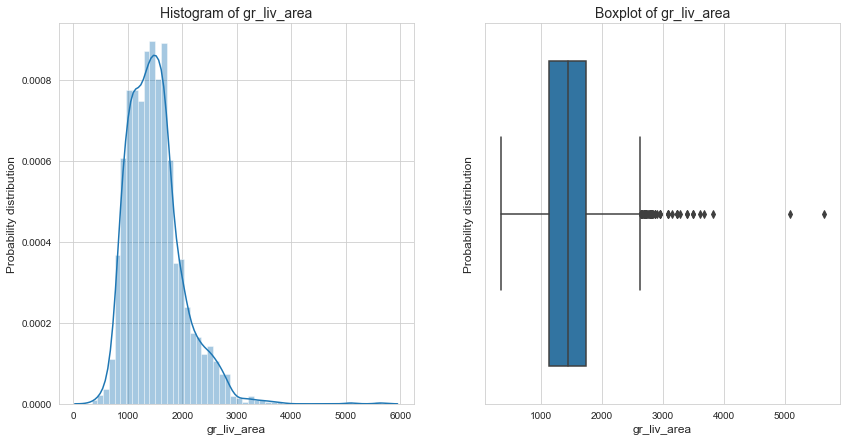

In [19]:
# Plot the Gr Liv Area
df = X1_trn
col = 'gr_liv_area'

titles = ['Histogram of ' + str(col), 'Boxplot of ' + str(col) ]
xlabels = [col, col]
ylabels = ['Probability distribution', 'Probability distribution']

single_hist_box(df, col, titles, xlabels, ylabels, (14,7))
 

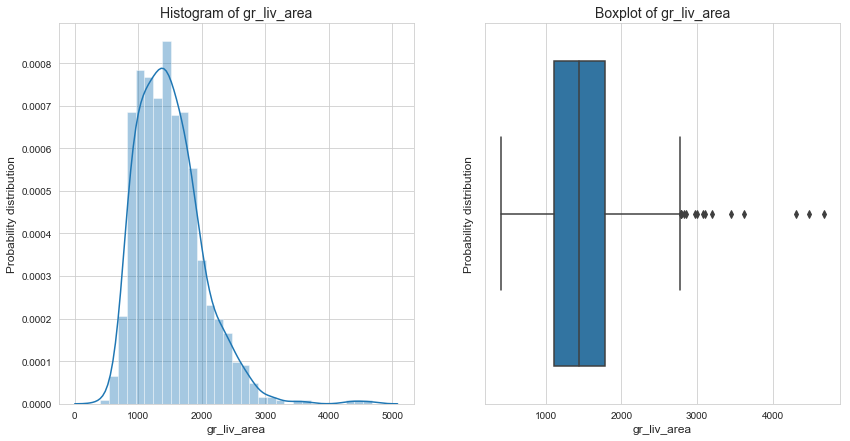

In [20]:
# Plot the Gr Liv Area
df = X1_tst
col = 'gr_liv_area'

titles = ['Histogram of ' + str(col), 'Boxplot of ' + str(col) ]
xlabels = [col, col]
ylabels = ['Probability distribution', 'Probability distribution']

single_hist_box(df, col, titles, xlabels, ylabels, (14,7))
 

## Examine categorical variables


In [21]:
# Compare the categorical variables in the train and test sets
df_list = [X1_trn, X1_tst]

for col in cat_features:
    compare_value_counts(df_list, col)

Column: ms_subclass 
         Dataframe 0          Dataframe 1 

        20        770         20        309
        60        394         60        181
        50        198         50         89
       120        132        120         60
        30        101         30         38
        70         90         70         38
       160         88        160         41
        80         86         80         32
        90         75         90         34
       190         46        190         15
        85         28         85         20
        75         16         75          7
        45         11         45          7
       180         11        180          6
        40          4         40          2
       150          1        150          0


Column:  ms_zoning 
         Dataframe 0          Dataframe 1 

        RL       1598         RL        675
        RM        316         RM        146
        FV        101         FV         38
   C (all)         19    C (all) 

      RRAn          1       RRAn          0


Column: roof_style 
         Dataframe 0          Dataframe 1 

     Gable       1619      Gable        702
       Hip        397        Hip        154
      Flat         13       Flat          7
   Gambrel         12    Gambrel         10
   Mansard          7    Mansard          4
      Shed          3       Shed          2


Column:  roof_matl 
         Dataframe 0          Dataframe 1 

   CompShg       2025    CompShg        862
   Tar&Grv         15    Tar&Grv          8
   WdShngl          5    WdShngl          2
   WdShake          4    WdShake          5
   Membran          1    Membran          0
   ClyTile          1    ClyTile          0


Column:    ext_1st 
         Dataframe 0          Dataframe 1 

   VinylSd        724    VinylSd        302
   MetalSd        331    MetalSd        119
   HdBoard        300    HdBoard        142
   Wd Sdng        276    Wd Sdng        144
   Plywood        152    Plywood         69
   CemntBd

In [22]:
# Combine the test and training data sets to create categorical variables
X1_trn['ID'] = 'train'
X1_tst['ID'] = 'test'
X_super = pd.concat(df_list)
print(X_super.shape, X1_trn.shape, X1_tst.shape)

X_super.sort_values(by = 'ID', ascending = False).head()

# reference
# https://stackoverflow.com/questions/48758744/creating-dummy-variables-for-multiple-cateogorical-variables-in-python

(2930, 74) (2051, 74) (879, 74)


ms_subclass ms_zoning  lot_area    util lot_config    neigh bld_type  \
0              60        RL     13517  AllPub    CulDSac   Sawyer     1Fam   
1283           60        RL     13426  AllPub     Corner  CollgCr     1Fam   
1377           90        RL     10791  AllPub     Inside   Sawyer   Duplex   
1376           70        RH      8525  AllPub     Inside    SWISU     1Fam   
1375          120        RL      6289  AllPub     Inside  NridgHt   TwnhsE   

     hs_style  over_qual  over_cond  ...  pvd_drive  wood_dck_sf opn_prch_sf  \
0      2Story          6          8  ...          Y            0          44   
1283   2Story          7          5  ...          Y          208         107   
1377   1Story          4          5  ...          Y            0           0   
1376   2Story          5          6  ...          N            0         192   
1375   1Story          6          5  ...          Y          192          28   

     3sn_prch scrn_prch  pool_area misc_val 1st_flr_sf  2nd_flr_sf     ID  
0           0         0          0        0        725         754  train  
1283        0         0          0        0        951         828  train  
1377        0         0          0      500       1296           0  train  
1376        0         0          0        0       1024         940  train  
1375        0         0          0        0       1362           0  train  

[5 rows x 74 columns]

In [23]:
# Create categorical variables
X_super = pd.get_dummies(X_super, columns = cat_features, drop_first=True)
print(X_super.shape)
print(X_super.columns)


(2930, 275)
Index(['lot_area', 'over_qual', 'over_cond', 'yr_built', 'yr_remodel',
       'tot_bsmt_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath',
       'full_bath',
       ...
       'garg_qlty_NA', 'garg_qlty_Po', 'garg_qlty_TA', 'garg_cnd_Fa',
       'garg_cnd_Gd', 'garg_cnd_NA', 'garg_cnd_Po', 'garg_cnd_TA',
       'pvd_drive_P', 'pvd_drive_Y'],
      dtype='object', length=275)


## Create new variables

In [24]:
# Create an age of home variable at time of sale and age of remodel
X_super['age_home_at_sale'] = X_super['yr_sold'] - X_super['yr_built']
X_super['age_remodel_at_sale'] = X_super['yr_sold'] - X_super['yr_remodel']

# Drop columns
X_super = X_super.drop(columns = ['yr_built', 'yr_remodel'])


In [25]:
# Update num_features
num_features = ['lot_area', 'over_qual', 'over_cond',
                'tot_bsmt_sf', 'gr_liv_area', 'bsmt_full_bath',
                'bsmt_half_bath', 'full_bath', 'half_bath', 'bed_abvgr',
                'enc_porch', 'mon_sold', 'yr_sold', 'mas_vnr_area', 'bsmt_fin_sf',
                'bsmt_fin_sf_2','bsmt_unf_sf','low_qual_fin_sf','kitch_abv_gr','tot_rms_abv_grd',
                'fireplcs','garg_cars', 'garg_area','wood_dck_sf', 'opn_prch_sf',
                '3sn_prch', 'scrn_prch', 'pool_area','misc_val','1st_flr_sf', '2nd_flr_sf',
                'age_home_at_sale','age_remodel_at_sale']

X_super[num_features].head()

lot_area  over_qual  over_cond  tot_bsmt_sf  gr_liv_area  bsmt_full_bath  \
0     13517          6          8        725.0         1479             0.0   
1     11492          7          5        913.0         2122             1.0   
2      7922          5          7       1057.0         1057             1.0   
3      9802          5          5        384.0         1444             0.0   
4     14235          6          8        676.0         1445             0.0   

   bsmt_half_bath  full_bath  half_bath  bed_abvgr  ...  wood_dck_sf  \
0             0.0          2          1          3  ...            0   
1             0.0          2          1          4  ...            0   
2             0.0          1          0          3  ...            0   
3             0.0          2          1          3  ...          100   
4             0.0          2          0          3  ...            0   

   opn_prch_sf  3sn_prch  scrn_prch  pool_area  misc_val  1st_flr_sf  \
0           44         0          0          0         0         725   
1           74         0          0          0         0         913   
2           52         0          0          0         0        1057   
3            0         0          0          0         0         744   
4           59         0          0          0         0         831   

   2nd_flr_sf  age_home_at_sale  age_remodel_at_sale  
0         754                34                    5  
1        1209                13                   12  
2           0                57                    3  
3         700                 4                    3  
4         614               110                   17  

[5 rows x 33 columns]

## Examine the numerical data

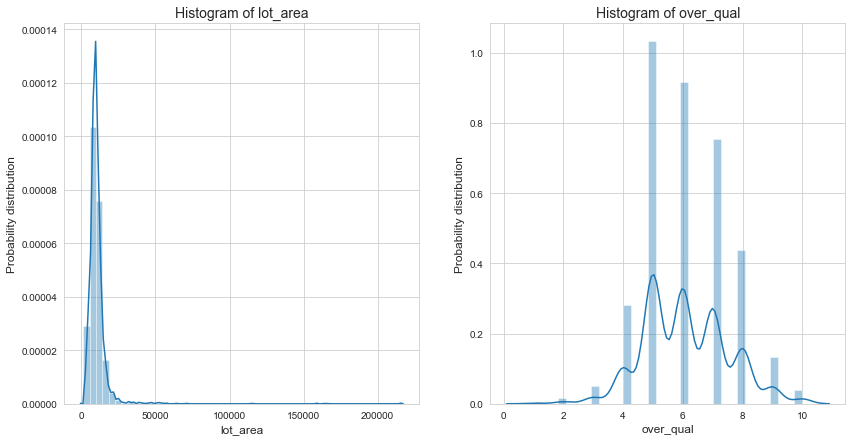

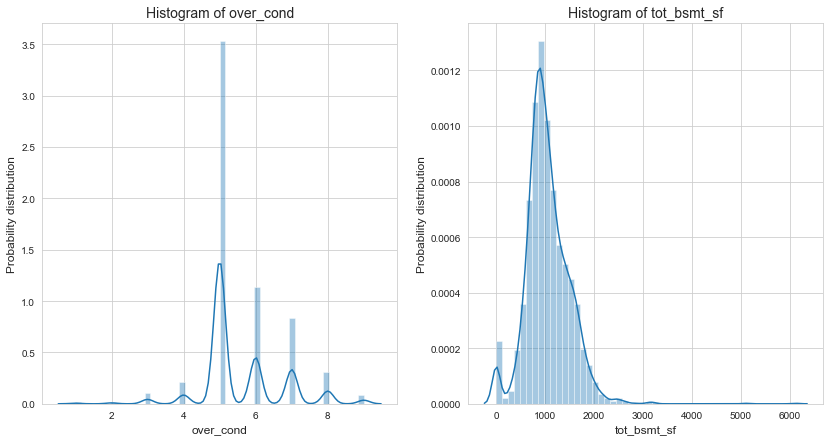

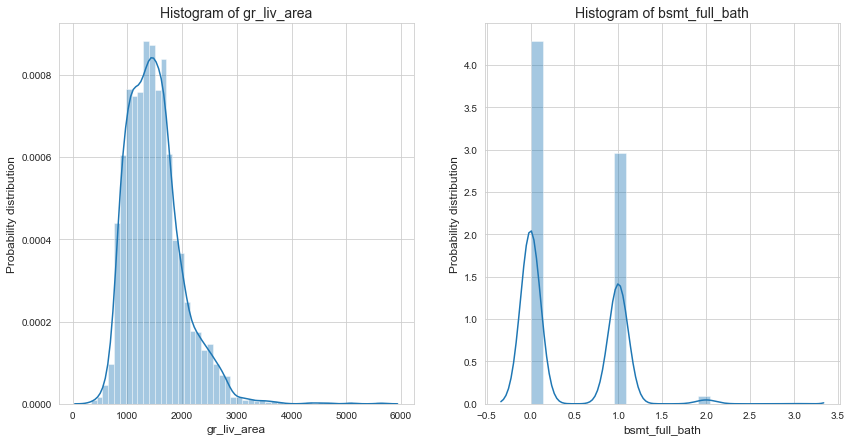

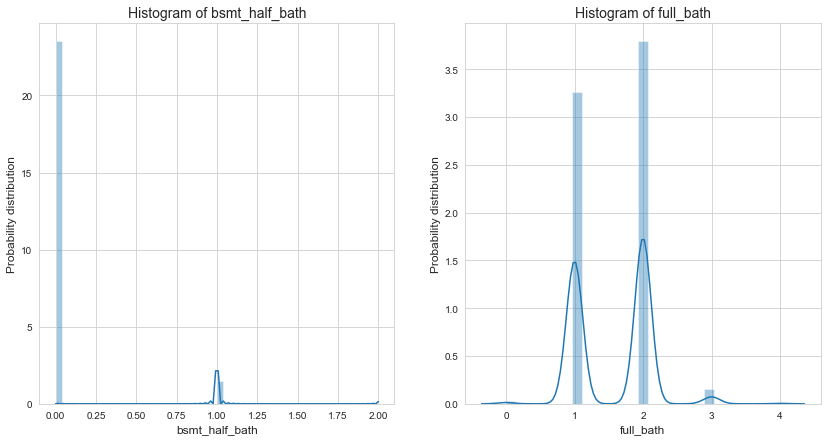

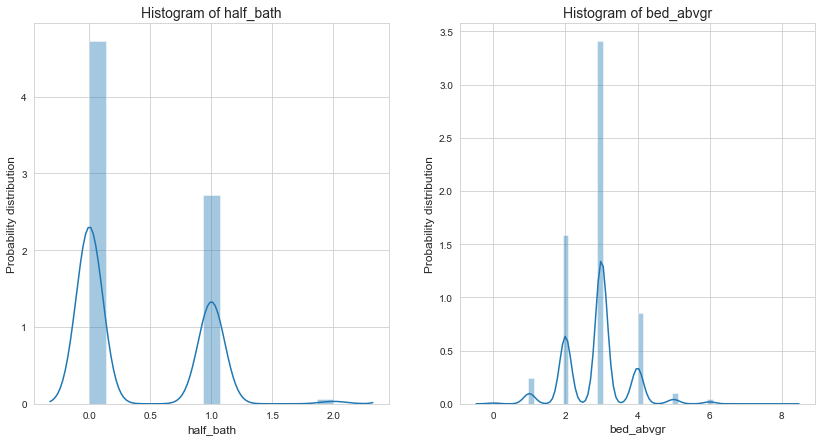

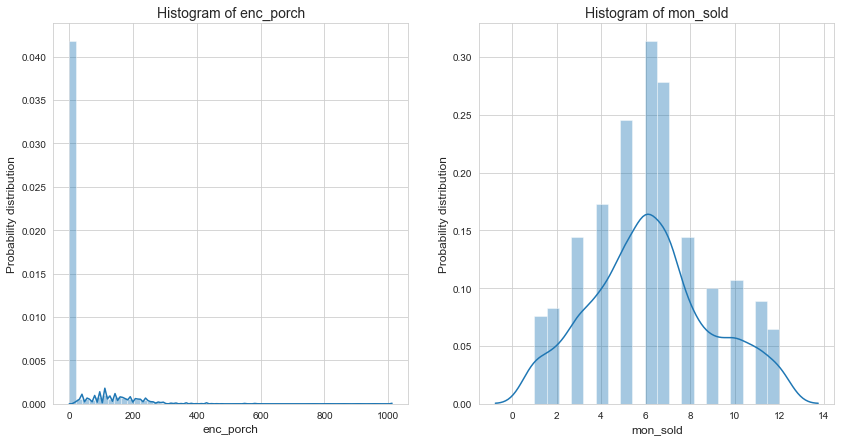

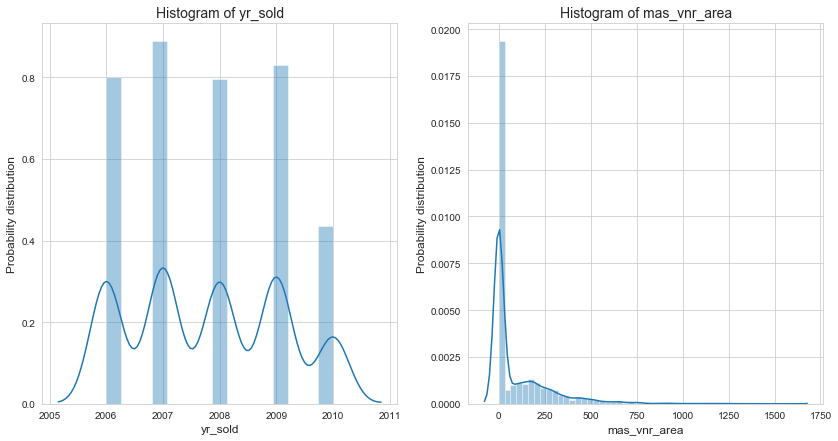

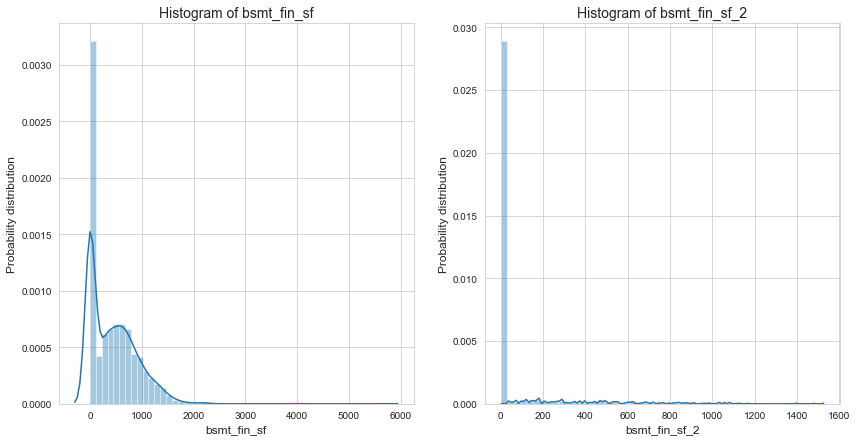

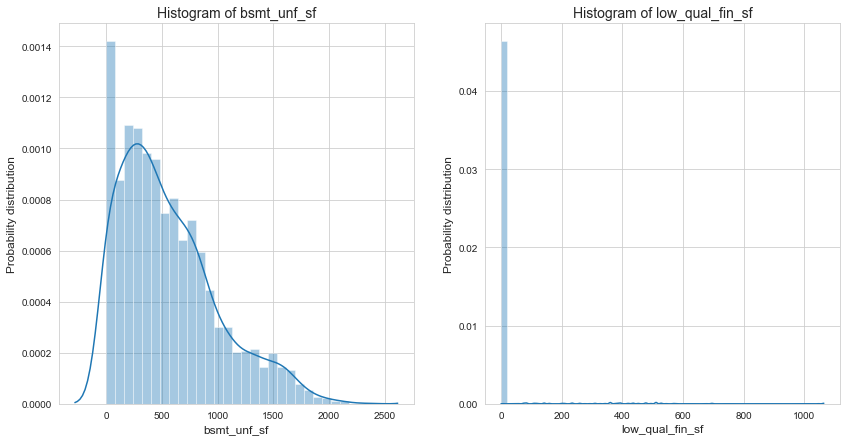

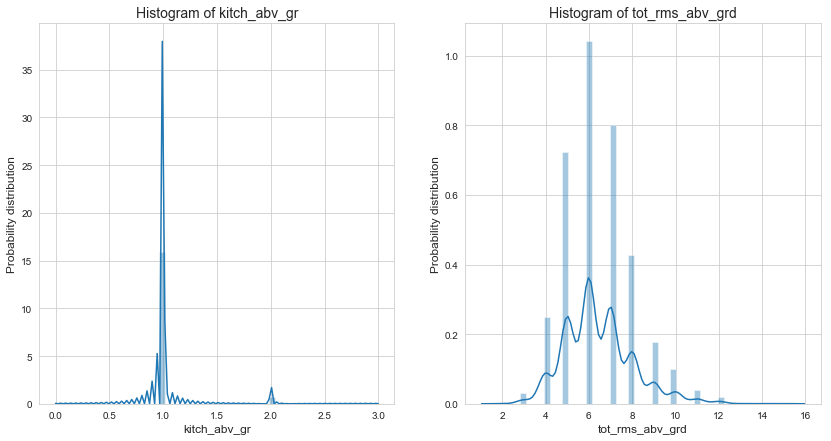

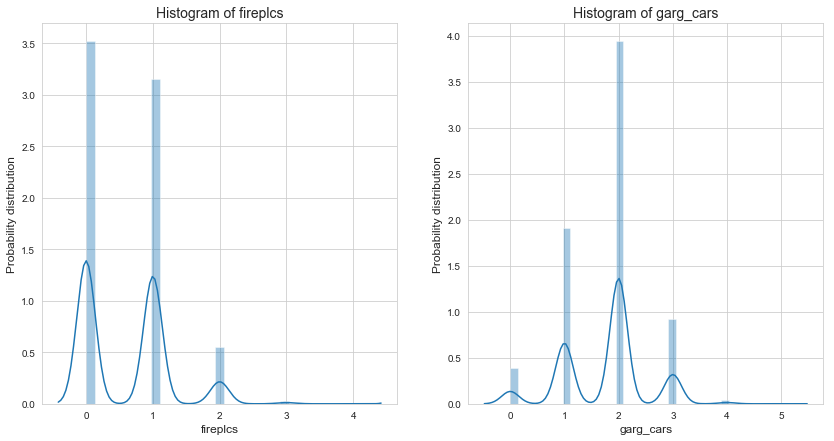

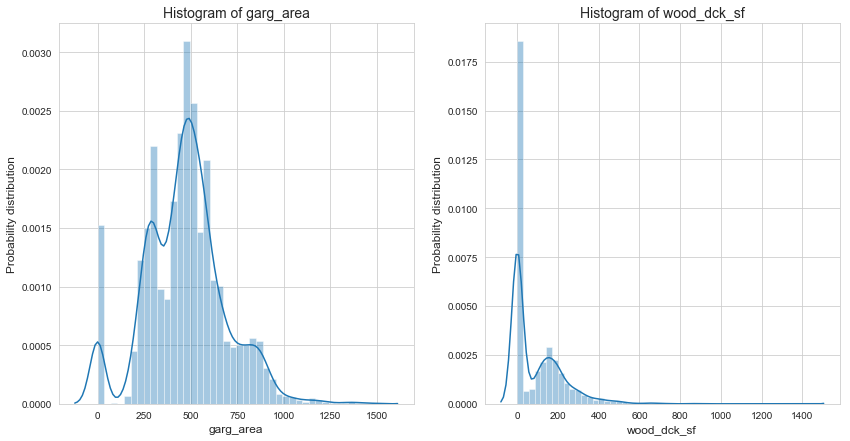

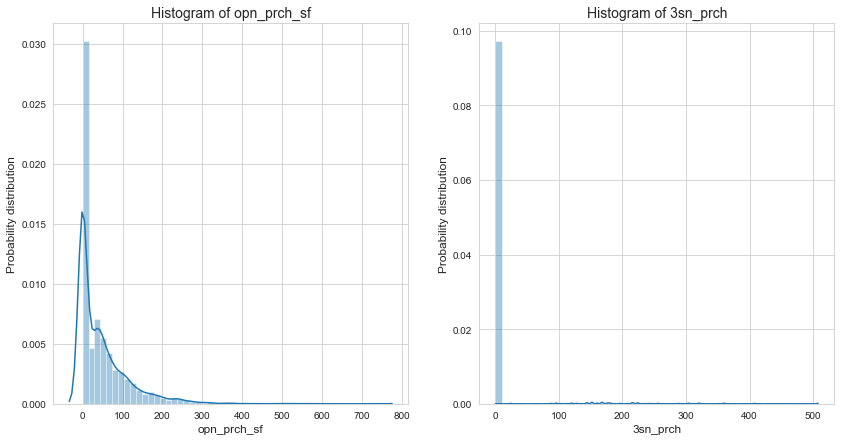

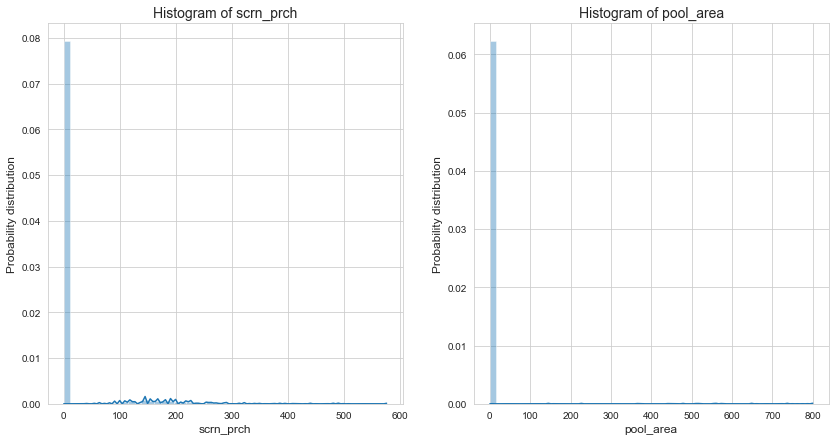

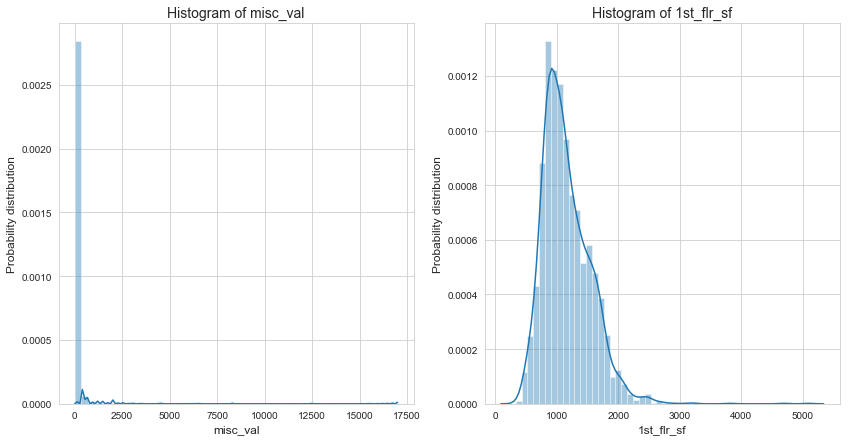

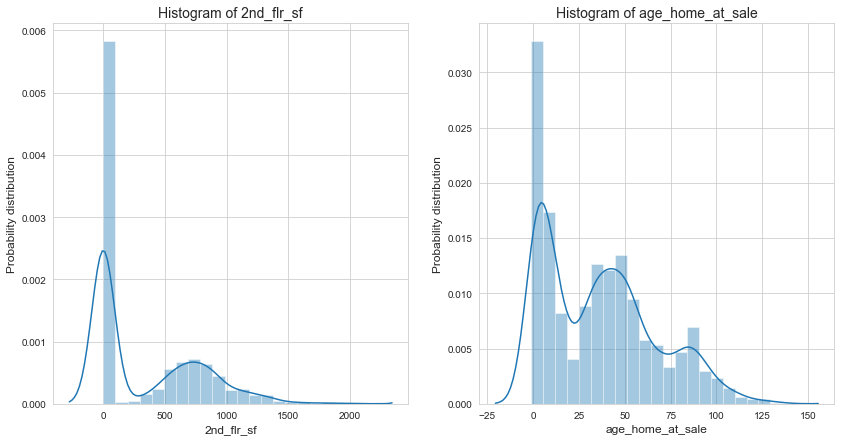

In [26]:
# plot histograms for each numeric variable

for i in range(0, len(num_features) - 2, 2):
    df = X_super
    cols = num_features[i : i + 2]
    titles = ['Histogram of ' + str(cols[0]), 'Histogram of ' + str(cols[1]) ]
    xlabels = cols
    ylabels = ['Probability distribution', 'Probability distribution']

    subplot_histograms(df, cols, titles, xlabels, ylabels, (14,7))


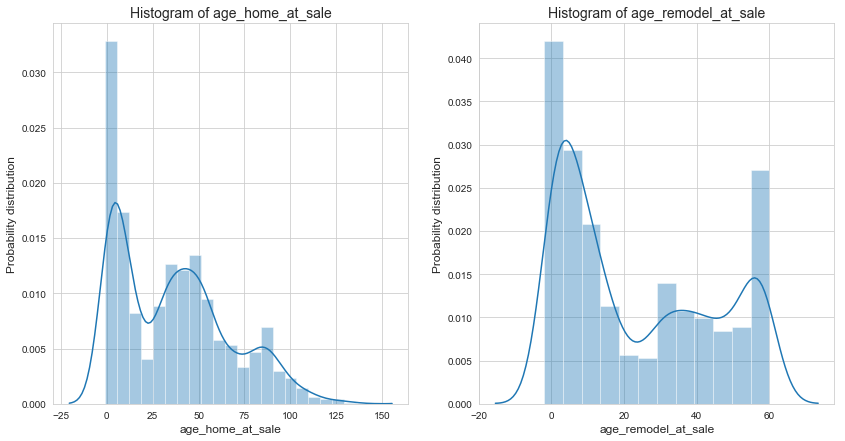

In [27]:
df = X_super
cols = num_features[-2:]
titles = ['Histogram of ' + str(cols[0]), 'Histogram of ' + str(cols[1]) ]
xlabels = cols
ylabels = ['Probability distribution', 'Probability distribution']

subplot_histograms(df, cols, titles, xlabels, ylabels, (14,7))

## Redivide the data and save to data files


In [28]:
# redivide the data use the ID column
X1_trn = X_super[X_super['ID'] == 'train'].drop(columns = ['ID'])
X1_tst = X_super[X_super['ID'] == 'test'].drop(columns = ['ID'])
print(X_super.shape, X1_trn.shape, X1_tst.shape)

X1_tst.head()

(2930, 275) (2051, 274) (879, 274)


lot_area  over_qual  over_cond  tot_bsmt_sf  gr_liv_area  bsmt_full_bath  \
0      9142          6          8       1020.0         1928             0.0   
1      9662          5          4       1967.0         1967             0.0   
2     17104          7          5        654.0         1496             1.0   
3      8520          5          6        968.0          968             0.0   
4      9500          6          5       1394.0         1394             1.0   

   bsmt_half_bath  full_bath  half_bath  bed_abvgr  ...  garg_qlty_TA  \
0             0.0          2          0          4  ...             0   
1             0.0          2          0          6  ...             1   
2             0.0          2          1          3  ...             1   
3             0.0          1          0          2  ...             0   
4             0.0          1          1          3  ...             1   

   garg_cnd_Fa  garg_cnd_Gd  garg_cnd_NA  garg_cnd_Po  garg_cnd_TA  \
0            0            0            0            1            0   
1            0            0            0            0            1   
2            0            0            0            0            1   
3            0            0            0            0            1   
4            0            0            0            0            1   

   pvd_drive_P  pvd_drive_Y  age_home_at_sale  age_remodel_at_sale  
0            0            1                96                   56  
1            0            1                29                   29  
2            0            1                 0                    0  
3            0            0                84                    1  
4            0            1                46                   46  

[5 rows x 274 columns]

## Save the predictor dataframes to files


In [29]:
# Save the data to csv files
test_dataframe_name = "test_clean.csv"
train_dataframe_name = "train_clean.csv"

X1_tst.to_csv(os.path.join(data_path, test_dataframe_name), index = False)
X1_trn.to_csv(os.path.join(data_path, train_dataframe_name), index = False)


## Examine the target variable

In [30]:
# Set up the training and testing
y_trn = a_trn[targ]
y_trn.rename(columns = {'SalePrice':'sale_price'}, inplace = True)


print(y_trn.shape)
y_trn.head()


(2051, 1)


sale_price
0      130500
1      220000
2      109000
3      174000
4      138500

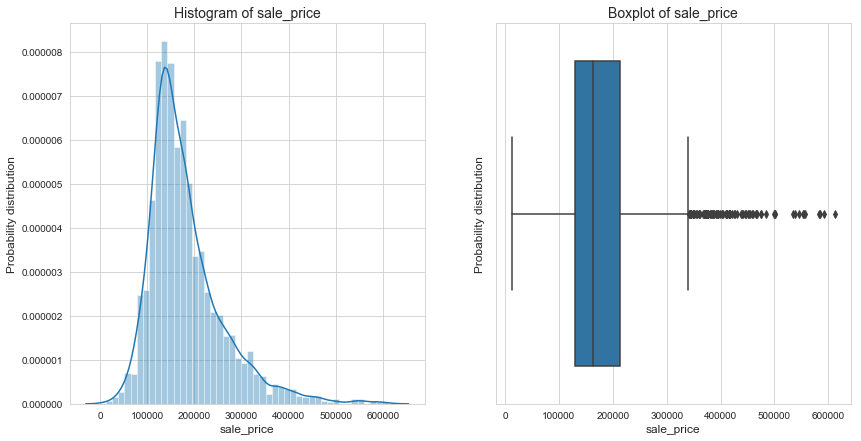

In [31]:
# Plot the dependent variable
df = y_trn
col = 'sale_price'

titles = ['Histogram of ' + str(col), 'Boxplot of ' + str(col) ]
xlabels = [col, col]
ylabels = ['Probability distribution', 'Probability distribution']

single_hist_box(df, col, titles, xlabels, ylabels, (14,7))
 

In [32]:
# Save the y data to csv file
y_trn_dataframe_name = "y_clean.csv"

y_trn.to_csv(os.path.join(data_path, y_trn_dataframe_name), index = False)


## Data dictionary

SalePrice - the property's sale price in dollars. 

MSSubClass: The building class
20 1-STORY 1946 & NEWER ALL STYLES
30 1-STORY 1945 & OLDER
40 1-STORY W/FINISHED ATTIC ALL AGES
45 1-1/2 STORY - UNFINISHED ALL AGES
50 1-1/2 STORY FINISHED ALL AGES
60 2-STORY 1946 & NEWER
70 2-STORY 1945 & OLDER
75 2-1/2 STORY ALL AGES
80 SPLIT OR MULTI-LEVEL
85 SPLIT FOYER
90 DUPLEX - ALL STYLES AND AGES
120 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
150 1-1/2 STORY PUD - ALL AGES
160 2-STORY PUD - 1946 & NEWER
180 PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
190 2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
A Agriculture
C Commercial
FV Floating Village Residential
I Industrial
RH Residential High Density
RL Residential Low Density
RP Residential Low Density Park
RM Residential Medium Density

LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

Street: Type of road access to property
Grvl Gravel
Pave Paved

Alley: Type of alley access to property
Grvl Gravel
Pave Paved
NA No alley access

LotShape: General shape of property
Reg Regular
IR1 Slightly irregular
IR2 Moderately Irregular
IR3 Irregular

LandContour: Flatness of the property
Lvl Near Flat/Level
Bnk Banked - Quick and significant rise from street grade to building
HLS Hillside - Significant slope from side to side
Low Depression

Utilities: Type of utilities available
AllPub All public Utilities (E,G,W,& S)
NoSewr Electricity, Gas, and Water (Septic Tank)
NoSeWa Electricity and Gas Only
ELO Electricity only

LotConfig: Lot configuration
Inside Inside lot
Corner Corner lot
CulDSac Cul-de-sac
FR2 Frontage on 2 sides of property
FR3 Frontage on 3 sides of property

LandSlope: Slope of property
Gtl Gentle slope
Mod Moderate Slope
Sev Severe Slope

Neighborhood: Physical locations within Ames city limits
Blmngtn Bloomington Heights
Blueste Bluestem
BrDale Briardale
BrkSide Brookside
ClearCr Clear Creek
CollgCr College Creek
Crawfor Crawford
Edwards Edwards
Gilbert Gilbert
IDOTRR Iowa DOT and Rail Road
MeadowV Meadow Village
Mitchel Mitchell
Names North Ames
NoRidge Northridge
NPkVill Northpark Villa
NridgHt Northridge Heights
NWAmes Northwest Ames
OldTown Old Town
SWISU South & West of Iowa State University
Sawyer Sawyer
SawyerW Sawyer West
Somerst Somerset
StoneBr Stone Brook
Timber Timberland
Veenker Veenker

Condition1: Proximity to main road or railroad
Artery Adjacent to arterial street
Feedr Adjacent to feeder street
Norm Normal
RRNn Within 200' of North-South Railroad
RRAn Adjacent to North-South Railroad
PosN Near positive off-site feature--park, greenbelt, etc.
PosA Adjacent to postive off-site feature
RRNe Within 200' of East-West Railroad
RRAe Adjacent to East-West Railroad

Condition2: Proximity to main road or railroad (if a second is present)
Artery Adjacent to arterial street
Feedr Adjacent to feeder street
Norm Normal
RRNn Within 200' of North-South Railroad
RRAn Adjacent to North-South Railroad
PosN Near positive off-site feature--park, greenbelt, etc.
PosA Adjacent to postive off-site feature
RRNe Within 200' of East-West Railroad
RRAe Adjacent to East-West Railroad

BldgType: Type of dwelling
1Fam Single-family Detached
2FmCon Two-family Conversion; originally built as one-family dwelling
Duplx Duplex
TwnhsE Townhouse End Unit
TwnhsI Townhouse Inside Unit

HouseStyle: Style of dwelling
1Story One story
1.5Fin One and one-half story: 2nd level finished
1.5Unf One and one-half story: 2nd level unfinished
2Story Two story
2.5Fin Two and one-half story: 2nd level finished
2.5Unf Two and one-half story: 2nd level unfinished
SFoyer Split Foyer
SLvl Split Level

OverallQual: Overall material and finish quality
10 Very Excellent
9 Excellent
8 Very Good
7 Good
6 Above Average
5 Average
4 Below Average
3 Fair
2 Poor
1 Very Poor

OverallCond: Overall condition rating
10 Very Excellent
9 Excellent
8 Very Good
7 Good
6 Above Average
5 Average
4 Below Average
3 Fair
2 Poor
1 Very Poor

YearBuilt: Original construction date

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

RoofStyle: Type of roof
Flat Flat
Gable Gable
Gambrel Gabrel (Barn)
Hip Hip
Mansard Mansard
Shed Shed

RoofMatl: Roof material
ClyTile Clay or Tile
CompShg Standard (Composite) Shingle
Membran Membrane
Metal Metal
Roll Roll
Tar&Grv Gravel & Tar
WdShake Wood Shakes
WdShngl Wood Shingles
Exterior1st: Exterior covering on house
AsbShng Asbestos Shingles
AsphShn Asphalt Shingles
BrkComm Brick Common
BrkFace Brick Face
CBlock Cinder Block
CemntBd Cement Board
HdBoard Hard Board
ImStucc Imitation Stucco
MetalSd Metal Siding
Other Other
Plywood Plywood
PreCast PreCast
Stone Stone
Stucco Stucco
VinylSd Vinyl Siding
Wd Sdng Wood Siding
WdShing Wood Shingles

Exterior2nd: Exterior covering on house (if more than one material)
AsbShng Asbestos Shingles
AsphShn Asphalt Shingles
BrkComm Brick Common
BrkFace Brick Face
CBlock Cinder Block
CemntBd Cement Board
HdBoard Hard Board
ImStucc Imitation Stucco
MetalSd Metal Siding
Other Other
Plywood Plywood
PreCast PreCast
Stone Stone
Stucco Stucco
VinylSd Vinyl Siding
Wd Sdng Wood Siding
WdShing Wood Shingles

MasVnrType: Masonry veneer type
BrkCmn Brick Common
BrkFace Brick Face
CBlock Cinder Block
None None
Stone Stone

MasVnrArea: Masonry veneer area in square feet

ExterQual: Exterior material quality
Ex Excellent
Gd Good
TA Average/Typical
Fa Fair
Po Poor

ExterCond: Present condition of the material on the exterior
Ex Excellent
Gd Good
TA Average/Typical
Fa Fair
Po Poor

Foundation: Type of foundation
BrkTil Brick & Tile
CBlock Cinder Block
PConc Poured Contrete
Slab Slab
Stone Stone
Wood Wood

BsmtQual: Height of the basement
Ex Excellent (100+ inches)
Gd Good (90-99 inches)
TA Typical (80-89 inches)
Fa Fair (70-79 inches)
Po Poor (<70 inches)
NA No Basement

BsmtCond: General condition of the basement
Ex Excellent
Gd Good
TA Typical - slight dampness allowed
Fa Fair - dampness or some cracking or settling
Po Poor - Severe cracking, settling, or wetness
NA No Basement

BsmtExposure: Walkout or garden level basement walls
Gd Good Exposure
Av Average Exposure (split levels or foyers typically score average or above)
Mn Mimimum Exposure
No No Exposure
NA No Basement

BsmtFinType1: Quality of basement finished area
GLQ Good Living Quarters
ALQ Average Living Quarters
BLQ Below Average Living Quarters
Rec Average Rec Room
LwQ Low Quality
Unf Unfinshed
NA No Basement

BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Quality of second finished area (if present)
GLQ Good Living Quarters
ALQ Average Living Quarters
BLQ Below Average Living Quarters
Rec Average Rec Room
LwQ Low Quality
Unf Unfinshed
NA No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

Heating: Type of heating
Floor Floor Furnace
GasA Gas forced warm air furnace
GasW Gas hot water or steam heat
Grav Gravity furnace
OthW Hot water or steam heat other than gas
Wall Wall furnace

HeatingQC: Heating quality and condition
Ex Excellent
Gd Good
TA Average/Typical
Fa Fair
Po Poor

CentralAir: Central air conditioning
N No
Y Yes

Electrical: Electrical system
SBrkr Standard Circuit Breakers & Romex
FuseA Fuse Box over 60 AMP and all Romex wiring (Average)
FuseF 60 AMP Fuse Box and mostly Romex wiring (Fair)
FuseP 60 AMP Fuse Box and mostly knob & tube wiring (poor)
Mix Mixed

1stFlrSF: First Floor square feet

2ndFlrSF: Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: Above grade (ground) living area square feet

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

FullBath: Full bathrooms above grade

HalfBath: Half baths above grade

Bedroom: Number of bedrooms above basement level

Kitchen: Number of kitchens

KitchenQual: Kitchen quality
Ex Excellent
Gd Good
TA Typical/Average
Fa Fair
Po Poor

TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

Functional: Home functionality rating
Typ Typical Functionality
Min1 Minor Deductions 1
Min2 Minor Deductions 2
Mod Moderate Deductions
Maj1 Major Deductions 1
Maj2 Major Deductions 2
Sev Severely Damaged
Sal Salvage only

Fireplaces: Number of fireplaces

FireplaceQu: Fireplace quality
Ex Excellent - Exceptional Masonry Fireplace
Gd Good - Masonry Fireplace in main level
TA Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
Fa Fair - Prefabricated Fireplace in basement
Po Poor - Ben Franklin Stove
NA No Fireplace

GarageType: Garage location
2Types More than one type of garage
Attchd Attached to home
Basment Basement Garage
BuiltIn Built-In (Garage part of house - typically has room above garage)
CarPort Car Port
Detchd Detached from home
NA No Garage

GarageYrBlt: Year garage was built

GarageFinish: Interior finish of the garage
Fin Finished
RFn Rough Finished
Unf Unfinished
NA No Garage

GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality
Ex Excellent
Gd Good
TA Typical/Average
Fa Fair
Po Poor
NA No Garage

GarageCond: Garage condition
Ex Excellent
Gd Good
TA Typical/Average
Fa Fair
Po Poor
NA No Garage

PavedDrive: Paved driveway
Y Paved
P Partial Pavement
N Dirt/Gravel

WoodDeckSF: Wood deck area in square feet

OpenPorchSF: Open porch area in square feet

EnclosedPorch: Enclosed porch area in square feet

3SsnPorch: Three season porch area in square feet

ScreenPorch: Screen porch area in square feet

PoolArea: Pool area in square feet

PoolQC: Pool quality
Ex Excellent
Gd Good
TA Average/Typical
Fa Fair
NA No Pool

Fence: Fence quality
GdPrv Good Privacy
MnPrv Minimum Privacy
GdWo Good Wood
MnWw Minimum Wood/Wire
NA No Fence

MiscFeature: Miscellaneous feature not covered in other categories
Elev Elevator
Gar2 2nd Garage (if not described in garage section)
Othr Other
Shed Shed (over 100 SF)
TenC Tennis Court
NA None

MiscVal: $Value of miscellaneous feature

MoSold: Month Sold

YrSold: Year Sold

SaleType: Type of sale
WD Warranty Deed - Conventional
CWD Warranty Deed - Cash
VWD Warranty Deed - VA Loan
New Home just constructed and sold
COD Court Officer Deed/Estate
Con Contract 15% Down payment regular terms
ConLw Contract Low Down payment and low interest
ConLI Contract Low Interest
ConLD Contract Low Down
Oth Other

# References

* https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
* https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data